### Deep Learning  Assignment
**by- ed24s401**

### ANSWER 1

Download the fashion-MNIST dataset and plot 1 sample image for each class as shown in the grid below. Use from keras.datasets import fashion_mnist for getting the fashion mnist dataset.

In [8]:
import numpy as np
import wandb
from keras.datasets import fashion_mnist
from keras.datasets import mnist
import matplotlib.pyplot as plt


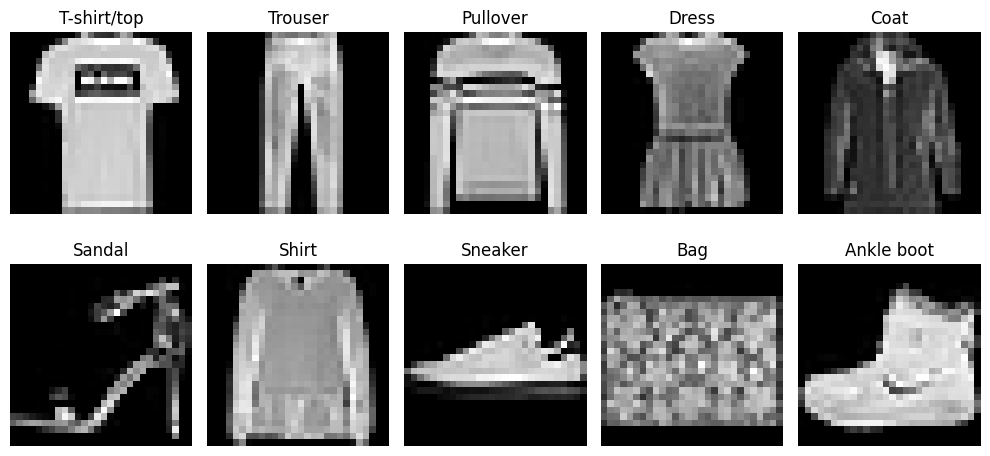

wandb: ERROR Control-C detected -- Run data was not synced


KeyboardInterrupt: 

In [9]:

wandb.init(project='test', name='fashion-MNIST samples')
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()
class_lbs=['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
fig, axes=plt.subplots(2,5, figsize=(10,5))
axes=axes.flatten()
marked_img=[]

for i in range(10):
    idx=np.where(y_train ==i)[0][0]
    axes[i].imshow(x_train[idx], cmap='gray')
    axes[i].set_title(class_lbs[i])
    axes[i].axis('off')
    marked_img.append(wandb.Image(x_train[idx], caption=class_lbs[i]))

plt.tight_layout() 
plt.show()
#logging figure to wandb
wandb.log({"fashion-MNIST samples": marked_img})
wandb.finish()



### ANSWER 2.

Implement a feedforward neural network which takes images from the fashion-mnist data as input and outputs a probability distribution over the 10 classes.

Your code should be flexible such that it is easy to change the number of hidden layers and the number of neurons in each hidden layer

In [ ]:

#loading the dataset
(x_train_full, y_train_full), (x_test,y_test)=fashion_mnist.load_data()
 
# normalize images
x_train_full=x_train_full.reshape(x_train_full.shape[0], -1)/255.0
x_test = x_test.reshape(x_test.shape[0], -1) / 255.0
#shuffle dataset
np.random.seed(42)
indices=np.arange(x_train_full.shape[0])
np.random.shuffle(indices)

x_train_full, y_train_full=x_train_full[indices], y_train_full[indices]

# splitting the dataset into training(85%) and validation(15%)
train_size=int(.85*len(x_train_full))

x_train, y_train=x_train_full[:train_size],y_train_full[:train_size]
x_val, y_val=x_train_full[train_size:], y_train_full[train_size:]

#converting truth(y) into one hot vector
t_classes=10
y_train_1h=np.eye(t_classes)[y_train]
y_val_1h=np.eye(t_classes)[y_val]
y_test_1h=np.eye(t_classes)[y_test]
# print(len(x_test))

# print(f"Train set: {x_train.shape}, Validation set: {x_val.shape}, Test set: {x_test.shape}") #Train set: (51000, 784), Validation set: (9000, 784), Test set: (10000, 784)
# print(f"\n{y_train_1h.shape},  {y_val_1h.shape}") #(51000, 10), (9000, 10)



In [ ]:

class feed_forward_NN2:

    def __init__(self, layers):
        self.layers=layers
        self.weights=[]
        self.biases=[]
        self.layer_n=len(layers)

        for i in range(self.layer_n-1):
            w=np.random.randn(self.layers[i],self.layers[i+1])*np.sqrt(2/self.layers[i]) #size(self.layers[i] x self.layers[i+1])
            b=np.zeros((1,self.layers[i+1])) #size(self.layers[i] x self.layers[i+1])
            self.weights.append(w)
            self.biases.append(b)

    def sigmoid(self,x):
        return 1/ (1+np.exp(-np.clip(x, -500, 500)))
    
    def softmax(self, x):
        exp_x=np.exp(x-np.max(x, axis=1, keepdims=True))
        return exp_x/np.sum(exp_x, axis=1, keepdims=True)
        
    def sig_derivative(self, x):
        return x*(1-x)
    
    def forward_pass(self,x):
        self.h=[x]
        for i in range(self.layer_n-2):
            a=np.dot(self.h[i], self.weights[i])+ self.biases[i]
            h=self.sigmoid(a)
            self.h.append(h)
        #Output_layer  _using_softmax
        a_out=np.dot(self.h[-1],self.weights[-1]) +self.biases[-1]
        h_out=self.softmax(a_out)
        self.h.append(h_out)
        return self.h
    
    def predicted_prob_distribution(self,x):
        y_cap=self.forward_pass(x)
        return y_cap[-1]

In [ ]:
hidden_layers=[128,64]
layers=[784]+hidden_layers+[10]
print(layers, '\n')

network=feed_forward_NN2(layers)
predictions=network.predicted_prob_distribution(x_train_full)

print('probaability distribution over 10 classes is \n',predictions)
print("shape of the preditions :",predictions.shape)


[784, 128, 64, 10] 

probaability distribution over 10 classes is 
 [[0.11452927 0.1957214  0.25370661 ... 0.06206364 0.11810719 0.08825023]
 [0.11847855 0.2026304  0.2574039  ... 0.06227903 0.11349867 0.08319885]
 [0.12857067 0.18869202 0.2670616  ... 0.05860327 0.11270174 0.07906325]
 ...
 [0.11940737 0.20153591 0.25191175 ... 0.06082405 0.11502835 0.08686776]
 [0.11510043 0.19273059 0.26058288 ... 0.06191339 0.12242102 0.08220833]
 [0.11903308 0.19551982 0.25559116 ... 0.06398071 0.11590744 0.07853687]]
shape of the preditions : (60000, 10)


### ANSWER 3

Implement the backpropagation algorithm with support for the following optimisation functions

- **sgd**
- **momentum based gradient descent**
- **nesterov accelerated gradient descent**
- **rmsprop**
- **adam**
- **nadam**

In [ ]:

class feed_forward_NN_3:

    def __init__(self, layers, optimizer, learning_rate, momentum, beta1, beta2, beta, epsilon):
        
        
        self.layers=layers
        self.layer_n=len(layers)
        self.optimizer= optimizer.lower()
        self.lr=learning_rate
        self.momentum=momentum
        self.beta1=beta1
        self.beta2=beta2
        self.beta=beta
        self.epsilon=epsilon

        self.weights=[]
        self.biases=[]
        
        

        for i in range(self.layer_n-1):
            # initialization for hidden layers
            w=np.random.randn(layers[i],layers[i+1])*np.sqrt(2.0/layers[i]) #size(self.layers[i] x self.layers[i+1])
            b=np.zeros((1,layers[i+1])) #size(self.layers[i] x self.layers[i+1])
            self.weights.append(w)
            self.biases.append(b)

        # initialization of extra parameters for diff optimizers
        self._init_optim_params()

    def _init_optim_params(self):

        # common for  momentum, NAG, Adam, etc.
        if self.optimizer in ["momentum", "nesterov", "adam", "nadam", "rmsprop"]:
            self.v_w=[np.zeros_like(w) for w in self.weights]
            self.v_b=[np.zeros_like(b) for b in self.biases]


        # Adam or Nadam ( first moment and time step)
        if self.optimizer in ["adam","nadam"]:
            self.m_w =[np.zeros_like(w) for w in self.weights]
            self.m_b =[np.zeros_like(b) for b in self.biases]
            self.t =0


    def sigmoid(self,x):
        return 1/ (1+np.exp(-np.clip(x, -500, 500)))
    
    def softmax(self, x):
        exp_x=np.exp(x-np.max(x, axis=1, keepdims=True))
        return exp_x/np.sum(exp_x, axis=1, keepdims=True)
        
    def sig_derivative(self, x):
        return x*(1-x)
    
    def forward_pass(self,x):
        self.h=[x]
        for i in range(self.layer_n-2):
            a=np.dot(self.h[i], self.weights[i])+ self.biases[i]
            h=self.sigmoid(a)
            self.h.append(h)
        #Output_layer  _using_softmax
        a_out=np.dot(self.h[-1],self.weights[-1]) +self.biases[-1]
        h_out=self.softmax(a_out)
        self.h.append(h_out)
        return self.h
    
    def backward_prop(self,y_true):
        #batch_len=len(x)
        m = y_true.shape[0]
        dw = [None] * (self.layer_n - 1)
        db = [None] * (self.layer_n - 1)

        #gradient with respect to outpur layer
        delta=self.h[-1]-y_true
        #gradient wit respect to hidden layers
        for i in reversed(range(self.layer_n-1)):
            dw[i]=np.dot(self.h[i].T, delta)/m
            db[i]=np.sum(delta,axis=0,keepdims=True)/m

            if i>0:
                delta=np.dot(delta,self.weights[i].T)*self.sig_derivative(self.h[i])

        return dw, db
    
    def _update_params(self, dw, db):

        if self.optimizer =="sgd":
            #Stochastic Gradient Descent
            for i in range(self.layer_n -1):
                self.weights[i]-= self.lr *dw[i]
                self.biases[i]-= self.lr* db[i]

        elif self.optimizer =="momentum":
            for i in range(self.layer_n -1):
                self.v_w[i]= self.momentum*self.v_w[i] +dw[i]
                self.v_b[i]= self.momentum*self.v_b[i]+db[i]

                self.weights[i]-= self.lr*self.v_w[i]
                self.biases[i] -= self.lr*self.v_b[i]               

        elif self.optimizer =="rmsprop":
            for i in range(self.layer_n-1):
                self.v_w[i] = self.beta * self.v_w[i] + (1 - self.beta) * (dw[i] ** 2)
                self.v_b[i] = self.beta * self.v_b[i] + (1 - self.beta) * (db[i] ** 2)
                self.weights[i] -= self.lr * dw[i] / (np.sqrt(self.v_w[i] )+ self.epsilon)
                self.biases[i]  -= self.lr * db[i] / (np.sqrt(self.v_b[i] )+ self.epsilon)

        elif self.optimizer == "adam":
            self.t += 1
            for i in range(self.layer_n - 1):
                self.m_w[i] = self.beta1 * self.m_w[i] + (1 - self.beta1) * dw[i]
                self.m_b[i] = self.beta1 * self.m_b[i] + (1 - self.beta1) * db[i]
                self.v_w[i] = self.beta2 * self.v_w[i] + (1 - self.beta2) * (dw[i] ** 2)
                self.v_b[i] = self.beta2 * self.v_b[i] + (1 - self.beta2) * (db[i] ** 2)

                # bias correction
                m_w_hat = self.m_w[i] / (1 - self.beta1 ** self.t)
                m_b_hat = self.m_b[i] / (1 - self.beta1 ** self.t)
                v_w_hat = self.v_w[i] / (1 - self.beta2 ** self.t)
                v_b_hat = self.v_b[i] / (1 - self.beta2 ** self.t)

                self.weights[i] -= self.lr * m_w_hat / (np.sqrt(v_w_hat) + self.epsilon)
                self.biases[i]  -= self.lr * m_b_hat / (np.sqrt(v_b_hat) + self.epsilon)

        elif self.optimizer == "nadam":
            self.t += 1
            for i in range(self.layer_n - 1):
                self.m_w[i] = self.beta1 * self.m_w[i] + (1 - self.beta1) * dw[i]
                self.m_b[i] = self.beta1 * self.m_b[i] + (1 - self.beta1) * db[i]
                self.v_w[i] = self.beta2 * self.v_w[i] + (1 - self.beta2) * (dw[i] ** 2)
                self.v_b[i] = self.beta2 * self.v_b[i] + (1 - self.beta2) * (db[i] ** 2)

                # bias correction
                m_w_hat = self.m_w[i] / (1 - self.beta1 ** (self.t+1))
                m_b_hat = self.m_b[i] / (1 - self.beta1 ** (self.t+1))
                v_w_hat = self.v_w[i] / (1 - self.beta2 ** (self.t+1))
                v_b_hat = self.v_b[i] / (1 - self.beta2 ** (self.t+1))

                # final update
                grad_term_w = self.beta1 * m_w_hat + (1 - self.beta1) * dw[i] / (1 - self.beta1 ** (self.t+1))
                grad_term_b = self.beta1 * m_b_hat + (1 - self.beta1) * db[i] / (1 - self.beta1 ** (self.t+1))

                self.weights[i] -= self.lr * grad_term_w / (np.sqrt(v_w_hat) + self.epsilon)
                self.biases[i]  -= self.lr * grad_term_b / (np.sqrt(v_b_hat) + self.epsilon)
    
    def _train_step(self, x_batch, y_batch):
         
        if self.optimizer == "nesterov":
            # shit to look-ahead: w_look = w - momentum * v
            for i in range(self.layer_n - 1):
                self.weights[i] -= self.momentum * self.v_w[i]
                self.biases[i]  -= self.momentum * self.v_b[i]

            # forward + backward at the look-ahead position
            self.forward_pass(x_batch)
            out = self.h[-1]
            loss = -np.mean(np.sum(y_batch * np.log(out + 1e-10), axis=1)) 
            dW, dB = self.backward_prop(y_batch)

            # shift back to original w_t
            for i in range(self.layer_n - 1):
                self.weights[i] += self.momentum * self.v_w[i]
                self.biases[i]  += self.momentum * self.v_b[i]

            # update velocity: u_t = beta*u_{t-1} + grad_look
            for i in range(self.layer_n - 1):
                self.v_w[i] = self.momentum * self.v_w[i] + dW[i]
                self.v_b[i] = self.momentum * self.v_b[i] + dB[i]

            # final update: w_{t+1} = w_t - lr * u_t
            for i in range(self.layer_n - 1):
                self.weights[i] -= self.lr * self.v_w[i]
                self.biases[i]  -= self.lr * self.v_b[i]

            return loss

        else:
            # Normal forward/back
            self.forward_pass(x_batch)
            out = self.h[-1]
            loss = -np.mean(np.sum(y_batch * np.log(out + 1e-10), axis=1))

            # Backward pass
            dw, db = self.backward_prop(y_batch)

            # Update parameters with the chosen optimizer
            self._update_params(dw, db)

            return loss

    def training(self, x_train, y_train, x_val, y_val, epochs, batch_size,wandb_project):
        wandb.init(project=wandb_project, config={
            "optimizer": self.optimizer,
            "learning_rate": self.lr,
            "momentum": self.momentum,
            "beta1": self.beta1,
            "beta2": self.beta2,
            "beta": self.beta,
            "epsilon": self.epsilon,
            "epochs": epochs,
            "batch_size": batch_size,
            "layers": self.layers
        })


        #n_samples=len(x_train)
        for ep in range(epochs):

            # Shuffel data
            idx=np.random.permutation(x_train.shape[0])
            x_train_shuff=x_train[idx]
            y_train_shuff=y_train[idx]

            n_batches=len(x_train)// batch_size
            batch_no=0   
            epoch_loss=0

            for b in range(n_batches):
                start = b* batch_size
                end =start+batch_size
                x_batch=x_train_shuff[start: end]
                y_batch=y_train_shuff[start: end]

                # forward pass
                loss=self._train_step(x_batch, y_batch)
                batch_no+=1
                epoch_loss+=loss

            # average loss        
            loss_avg=epoch_loss/batch_no

            # use of validation dataset for predictions
            valid_prediction= self.predict(x_val)
            val_labels=np.argmax(y_val, axis =1)
            valid_accuracy=np.mean(valid_prediction ==val_labels)

            # loging in wandb
            wandb.log({'epoch':ep+1, 'training_loss' : loss_avg, 'validation_accuracy': valid_accuracy})
            print(f"epoch: {ep+1}/{epochs}, train_loss:{loss_avg:.5f}, val_accuracy: {valid_accuracy:.5f}")

        wandb.finish()
    


    def predict(self,x):
        y_cap=self.forward_pass(x)
        return np.argmax(y_cap[-1], axis=1)
    

if __name__=="__main__":
    optimizer_name="adam" # here you can choose any optimizer(available optimizers are 1. "sgd", 2. "momentum", 3. "nesterov", 4. "rmsprop", 5. "adam", 6. "nadam")

    model =feed_forward_NN_3(
        layers=[784, 128, 64, 10],
        optimizer=optimizer_name,
        learning_rate=0.001,
        momentum=0.9,
        beta1=0.9,
        beta2=0.999,
        beta=0.9,
        epsilon=1e-4,
    )
    model.training(
        x_train=x_train,
        y_train=y_train_1h,
        x_val=x_val,
        y_val=y_val_1h,
        epochs=25,
        batch_size=64,
        wandb_project="q4_sweep_project"
    )

    test_preds = model.predict(x_test)
    test_labels = np.argmax(y_test_1h, axis=1)
    test_acc = np.mean(test_preds == test_labels)
    print("Test Accuracy:", test_acc)





#### ANSWER 4 (10 Marks)

Use the sweep functionality provided by wandb to find the best values for the hyperparameters listed below. Use the standard train/test split of fashion_mnist (use (X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()). Keep 10% of the training data aside as validation data for this hyperparameter search. Here are some suggestions for different values to try for hyperparameters. As you can quickly see that this leads to an exponential number of combinations. You will have to think about strategies to do this hyperparameter search efficiently. Check out the options provided by wandb.sweep and write down what strategy you chose and why.

-number of epochs: 5, 10
-number of hidden layers: 3, 4, 5
-size of every hidden layer: 32, 64, 128
-weight decay (L2 regularisation): 0, 0.0005, 0.5
-learning rate: 1e-3, 1 e-4
-optimizer: sgd, momentum, nesterov, rmsprop, adam, nadam
-batch size: 16, 32, 64
-weight initialisation: random, Xavier
-activation functions: sigmoid, tanh, ReLU

#### Question 5 (5 marks)
We would like to see the best accuracy on the validation set across all the models that you train.

wandb automatically generates this plot which summarises the test accuracy of all the models that you tested. Please paste this plot below using the "Add Panel to Report" feature

#### Question 6 (20 Marks)
Based on the different experiments that you have run we want you to make some inferences about which configurations worked and which did not.

Here again, wandb automatically generates a "Parallel co-ordinates plot" and a "correlation summary" as shown below. Learn about a "Parallel co-ordinates plot" and how to read it.

By looking at the plots that you get, write down some interesting observations (simple bullet points but should be insightful). You can also refer to the plot in Question 5 while writing these insights. For example, in the above sample plot there are many configurations which give less than 65% accuracy. I would like to zoom into those and see what is happening.

I would also like to see a recommendation for what configuration to use to get close to 95% accuracy.

#### Question 7 (10 Marks)
For the best model identified above, report the accuracy on the test set of fashion_mnist and plot the confusion matrix as shown below. More marks for creativity (less marks for producing the plot shown below as it is)

In [ ]:
import numpy as np
import wandb
from keras.datasets import fashion_mnist


# Neural Network Class: feed_forward_NN_4

class feed_forward_NN_4:
    def __init__(self,
                 layers,
                 optimizer,
                 learning_rate,
                 momentum,
                 beta1,
                 beta2,
                 beta,
                 epsilon,
                 weight_decay,
                 init_type,
                 activation,
                 loss):
    
        
        self.layers = layers
        self.layer_n = len(layers)
        self.optimizer = optimizer.lower()
        self.lr = learning_rate
        self.momentum = momentum
        self.beta1 = beta1
        self.beta2 = beta2
        self.beta = beta
        self.epsilon = epsilon
        self.weight_decay = weight_decay
        self.init_type = init_type.lower()
        self.activation = activation.lower()
        self.loss =loss.lower()


                # Initialize Weights & BiaseS
        self.weights = []
        self.biases = []
        for i in range(self.layer_n - 1):
            if self.init_type == "xavier":
                # "Xavier" initialization
                w = np.random.randn(layers[i], layers[i+1]) * np.sqrt(1.0 / layers[i])
            else:
                # "random" initialization
                w = np.random.randn(layers[i], layers[i+1]) * np.sqrt(2.0 / layers[i])
            b = np.zeros((1, layers[i+1]))
            self.weights.append(w)
            self.biases.append(b)

        # initialize extra Params 
        if self.optimizer in ["momentum", "nag", "rmsprop", "adam", "nadam"]:
            self.v_w = [np.zeros_like(w) for w in self.weights]
            self.v_b = [np.zeros_like(b) for b in self.biases]
        if self.optimizer in ["adam", "nadam"]:
            self.m_w = [np.zeros_like(w) for w in self.weights]
            self.m_b = [np.zeros_like(b) for b in self.biases]
            self.t = 0

    # activations 
    def sigmoid(self, x):
        return 1 / (1 + np.exp(-np.clip(x, -500, 500)))
    
    def tanh(self, x):
        return np.tanh(x)
    
    def relu(self, x):
        return np.maximum(0, x)

    def activate(self, x):
        if self.activation == "sigmoid":
            return self.sigmoid(x)
        elif self.activation == "tanh":
            return self.tanh(x)
        elif self.activation == "relu":
            return self.relu(x)
        else:
            return self.sigmoid(x) 
        
    # derivatives
    def derivative(self, a):

        if self.activation == "sigmoid":
            return a * (1 - a)
        elif self.activation == "tanh":
            return 1 - a**2
        elif self.activation == "relu":
            return (a > 0).astype(float)
        else:
            return a * (1 - a) 

    def softmax(self, x):
        exp_x = np.exp(x - np.max(x, axis=1, keepdims=True))
        return exp_x / np.sum(exp_x, axis=1, keepdims=True)

    # Forward Pass
    def forward_pass(self, x):
        self.h = [x]  
        # Hidden layers
        for i in range(self.layer_n - 2):
            z = np.dot(self.h[i], self.weights[i]) + self.biases[i]
            act = self.activate(z)
            self.h.append(act)
        # Output layer- softmax
        z_out = np.dot(self.h[-1], self.weights[-1]) + self.biases[-1]
        out = self.softmax(z_out)
        self.h.append(out)
        return self.h

    # Backward Pass
    def backward_prop(self, y_true):
        m = y_true.shape[0]
        dw = [None] * (self.layer_n - 1)
        db = [None] * (self.layer_n - 1)

        # Cross-entropy derivative for output layer
        delta = self.h[-1] - y_true  # shape: (batch_size, output_dim)

        # Propagation
        for i in reversed(range(self.layer_n - 1)):
            dw[i] = np.dot(self.h[i].T, delta) / m
            db[i] = np.sum(delta, axis=0, keepdims=True) / m
            if i > 0:
                # For hidden layers, multiply by derivative of activation
                delta = np.dot(delta, self.weights[i].T) * self.derivative(self.h[i])
        return dw, db

    # Param Updates for "Non-nag" 
    def _update_params(self, dw, db):
        # Add weight decay to each gradient
        for i in range(self.layer_n - 1):
            dw[i] += self.weight_decay * self.weights[i]

        if self.optimizer == "sgd":
            for i in range(self.layer_n - 1):
                self.weights[i] -= self.lr * dw[i]
                self.biases[i] -= self.lr * db[i]

        elif self.optimizer == "momentum":
            for i in range(self.layer_n - 1):
                self.v_w[i] = self.momentum * self.v_w[i] + dw[i]
                self.v_b[i] = self.momentum * self.v_b[i] + db[i]
                self.weights[i] -= self.lr * self.v_w[i]
                self.biases[i] -= self.lr * self.v_b[i]

        elif self.optimizer == "rmsprop":
            for i in range(self.layer_n - 1):
                self.v_w[i] = self.beta * self.v_w[i] + (1 - self.beta) * (dw[i] ** 2)
                self.v_b[i] = self.beta * self.v_b[i] + (1 - self.beta) * (db[i] ** 2)
                self.weights[i] -= self.lr * dw[i] / (np.sqrt(self.v_w[i]) + self.epsilon)
                self.biases[i]  -= self.lr * db[i] / (np.sqrt(self.v_b[i]) + self.epsilon)

        elif self.optimizer == "adam":
            self.t += 1
            for i in range(self.layer_n - 1):
                self.m_w[i] = self.beta1 * self.m_w[i] + (1 - self.beta1) * dw[i]
                self.m_b[i] = self.beta1 * self.m_b[i] + (1 - self.beta1) * db[i]
                self.v_w[i] = self.beta2 * self.v_w[i] + (1 - self.beta2) * (dw[i] ** 2)
                self.v_b[i] = self.beta2 * self.v_b[i] + (1 - self.beta2) * (db[i] ** 2)

                # bias correction
                m_w_hat = self.m_w[i] / (1 - self.beta1 ** self.t)
                m_b_hat = self.m_b[i] / (1 - self.beta1 ** self.t)
                v_w_hat = self.v_w[i] / (1 - self.beta2 ** self.t)
                v_b_hat = self.v_b[i] / (1 - self.beta2 ** self.t)

                self.weights[i] -= self.lr * m_w_hat / (np.sqrt(v_w_hat) + self.epsilon)
                self.biases[i]  -= self.lr * m_b_hat / (np.sqrt(v_b_hat) + self.epsilon)

        elif self.optimizer == "nadam":
            self.t += 1
            for i in range(self.layer_n - 1):
                self.m_w[i] = self.beta1 * self.m_w[i] + (1 - self.beta1) * dw[i]
                self.m_b[i] = self.beta1 * self.m_b[i] + (1 - self.beta1) * db[i]
                self.v_w[i] = self.beta2 * self.v_w[i] + (1 - self.beta2) * (dw[i] ** 2)
                self.v_b[i] = self.beta2 * self.v_b[i] + (1 - self.beta2) * (db[i] ** 2)

                # bias correction
                m_w_hat = self.m_w[i] / (1 - self.beta1 ** (self.t + 1))
                m_b_hat = self.m_b[i] / (1 - self.beta1 ** (self.t + 1))
                v_w_hat = self.v_w[i] / (1 - self.beta2 ** (self.t + 1))
                v_b_hat = self.v_b[i] / (1 - self.beta2 ** (self.t + 1))

                grad_term_w = self.beta1 * m_w_hat + (1 - self.beta1) * dw[i] / (1 - self.beta1 ** (self.t + 1))
                grad_term_b = self.beta1 * m_b_hat + (1 - self.beta1) * db[i] / (1 - self.beta1 ** (self.t + 1))

                self.weights[i] -= self.lr * grad_term_w / (np.sqrt(v_w_hat) + self.epsilon)
                self.biases[i]  -= self.lr * grad_term_b / (np.sqrt(v_b_hat) + self.epsilon)

    # Training Step  with "nag"
    def _train_step(self, x_batch, y_batch):
        if self.optimizer == "nag":
            # to look-ahead: w_look = w - momentum * v
            for i in range(self.layer_n - 1):
                self.weights[i] -= self.lr*self.momentum * self.v_w[i]
                self.biases[i]  -= self.lr*self.momentum * self.v_b[i]

            # Forward at the look-ahead position
            self.forward_pass(x_batch)
            out = self.h[-1]
            l2_norm_weights, = 0
            for i in range(len(self.weights)):
                l2_norm_weights += np.sum(self.weights[i] ** 2)
            
                    
            l2_norm_params = l2_norm_weights #+ l2_norm_bias
            
            if self.loss=="cross_entropy":
                loss = -np.mean(np.sum(y_batch * np.log(out + 1e-10), axis = 1)) +  (self.weight_decay/2) * l2_norm_params # (1e-10) to prevent underflow
            elif self.loss=="mean_squared_error" :
                loss= 0.5 * np.mean(np.sum((out - y_batch)**2, axis=1))
            else:
                loss = -np.mean(np.sum(y_batch * np.log(out + 1e-10), axis = 1)) +  (self.weight_decay/2) * l2_norm_params
            #loss = -np.mean(np.sum(y_batch * np.log(out + 1e-10), axis=1))
            dW, dB = self.backward_prop(y_batch)

            # add weight decay here
            for i in range(self.layer_n - 1):
                dW[i] += self.weight_decay * self.weights[i]

            # backward at the look-ahead position (go back to w_t)
            for i in range(self.layer_n - 1):
                self.weights[i] += self.lr*self.momentum * self.v_w[i]
                self.biases[i]  += self.lr*self.momentum * self.v_b[i]

            # update velocity: u_t = momentum*u_{t-1} + dW
            for i in range(self.layer_n - 1):
                self.v_w[i] = self.momentum * self.v_w[i] + dW[i]
                self.v_b[i] = self.momentum * self.v_b[i] + dB[i]

            # final param update: w = w - lr*u_t
            for i in range(self.layer_n - 1):
                self.weights[i] -= self.lr * self.v_w[i]
                self.biases[i]  -= self.lr * self.v_b[i]

            return loss
        else:
            # Normal forward/back
            self.forward_pass(x_batch)
            out = self.h[-1]

            l2_norm_weights=0
            
            for i in range(len(self.weights)):
                l2_norm_weights += np.sum(self.weights[i] ** 2)
            
                    
            l2_norm_params = l2_norm_weights 
            
            if self.loss=="cross_entropy":
                loss = -np.mean(np.sum(y_batch * np.log(out + 1e-10), axis = 1)) +  (self.weight_decay/2) * l2_norm_params # (1e-10) to prevent underflow
            elif self.loss=="mean_squared_error" :
                loss= 0.5 * np.mean(np.sum((out - y_batch)**2, axis=1))
            else:
                loss = -np.mean(np.sum(y_batch * np.log(out + 1e-10), axis = 1)) +  (self.weight_decay/2) * l2_norm_params    
            
            dW, dB = self.backward_prop(y_batch)
            self._update_params(dW, dB)
            return loss

    # Outer Training Loop 
    def training(self, x_train, y_train, x_val, y_val, epochs, batch_size):
       
        for ep in range(epochs):
            idx = np.random.permutation(x_train.shape[0])
            x_train_shuff = x_train[idx]
            y_train_shuff = y_train[idx]
            n_batches = len(x_train) // batch_size
            epoch_loss = 0.0
            for b in range(n_batches):
                start = b * batch_size
                end = start + batch_size
                x_batch = x_train_shuff[start:end]
                y_batch = y_train_shuff[start:end]
                loss = self._train_step(x_batch, y_batch)
                epoch_loss += loss
            avg_loss = epoch_loss / n_batches

            # Validation

            preds = self.predict(x_val)
            val_labels = np.argmax(y_val, axis=1)
            val_acc = np.mean(preds == val_labels)

            val_outputs = self.forward_pass(x_val)[-1]

            l2_norm_weights=0
            
            for i in range(len(self.weights)):
                l2_norm_weights += np.sum(self.weights[i] ** 2)
                    
            l2_norm_params = l2_norm_weights 

            # Cross-entropy loss for validation

            if self.loss=="cross_entropy":
                val_loss = -np.mean(np.sum(y_val * np.log(val_outputs + 1e-10), axis = 1)) +  (self.weight_decay/2) * l2_norm_params # (1e-10) to prevent underflow
                
            # mean_mean_squared_error loss for validation

            elif self.loss=="mean_squared_error" :
                val_loss= 0.5 * np.mean(np.sum((val_outputs - y_val)**2, axis=1))
            else:
                val_loss = -np.mean(np.sum(y_val * np.log(val_outputs + 1e-10), axis = 1)) +  (self.weight_decay/2) * l2_norm_params


            # training accuracy
            preds_train = self.predict(x_train)
            train_labels = np.argmax(y_train, axis=1)
            train_acc = np.mean(preds_train == train_labels)


            # Log metrics to wandb
            wandb.log({"epoch": ep+1, "training_loss": avg_loss, "validation_accuracy": val_acc, "validation loss": val_loss, "training_acuracy": train_acc})
            print(f"Epoch {ep+1}/{epochs} - loss={avg_loss:.4f}, val_acc={val_acc:.4f}, val_loss={val_loss}" )

    #Prediction 
    def predict(self, X):
        self.forward_pass(X)
        return np.argmax(self.h[-1], axis=1)





# train_sweep() function

def train_sweep():
    # Initialize wandb
    wandb.init()
    config = wandb.config

    #custom run name from hyperparameters
    run_name = f"hl_{config.num_layers}_bs_{config.batch_size}_ac_{config.activation}_op_{config.optimizer}"
    wandb.run.name = run_name

    # Load Fashion-MNIST
    (x_train_full, y_train_full), (x_test, y_test) = fashion_mnist.load_data()
    x_train_full = x_train_full.reshape(x_train_full.shape[0], -1) / 255.0
    x_test = x_test.reshape(x_test.shape[0], -1) / 255.0

    np.random.seed(42)
    idx = np.arange(x_train_full.shape[0])
    np.random.shuffle(idx)
    x_train_full = x_train_full[idx]
    y_train_full = y_train_full[idx]

    # 90% training, 10% validation 
    train_size=int(.9*len(x_train_full))

    x_train, y_train=x_train_full[:train_size],y_train_full[:train_size]
    x_val, y_val=x_train_full[train_size:], y_train_full[train_size:]

    num_classes = 10
    y_train_1h = np.eye(num_classes)[y_train]
    y_val_1h = np.eye(num_classes)[y_val]
    y_test_1h = np.eye(num_classes)[y_test]

    # model
    model = feed_forward_NN_4(
        layers=[784] + [config.hidden_size] * config.num_layers + [10],
        optimizer=config.optimizer,
        learning_rate=config.learning_rate,
        momentum=config.momentum,
        beta1=config.beta1,
        beta2=config.beta2,
        beta=config.beta,
        epsilon=config.epsilon,
        weight_decay=config.weight_decay,
        init_type=config.init_type,
        activation=config.activation,
        loss=config.loss
    )

    # Train the model
    model.training(
        x_train=x_train,
        y_train=y_train_1h,
        x_val=x_val,
        y_val=y_val_1h,
        epochs=config.epochs,
        batch_size=config.batch_size
    )

    #Evaluation on test set
    test_preds = model.predict(x_test)
    test_labels = np.argmax(y_test_1h, axis=1)
    test_acc = np.mean(test_preds == test_labels)
    
    wandb.log({"test_accuracy": test_acc})
    print("test accuracy ",test_acc)


    # ANSWER 7 Confusion matrix

    wandb.log({"confusion_matrix": wandb.plot.confusion_matrix(probs=None,
                                                            y_true=test_labels,
                                                            preds=test_preds,
                                                            class_names=[str(i) for i in range(num_classes)])})

    
# sweep configuration
sweep_config = {
    "method": "random", 
    "metric": {
        "name": "validation_accuracy",
        "goal": "maximize"
    },
    "parameters": {
        "epochs": {"values": [5, 10]},
        "num_layers": {"values": [3, 4, 5]},
        "hidden_size": {"values": [32, 64, 128]},
        "weight_decay": {"values": [0.0, 0.0005, 0.5]},
        "learning_rate": {"values": [1e-3, 1e-4]},
        "optimizer": {"values": ["sgd", "momentum", "nag", "rmsprop", "adam", "nadam"]},
        "batch_size": {"values": [16, 32, 64]},
        "init_type": {"values": ["random", "xavier"]},
        "activation": {"values": ["sigmoid", "tanh", "relu"]},
        "momentum": {"values": [0.8, 0.9]},
        "beta1": {"values": [0.9]},
        "beta2": {"values": [0.999]},
        "beta": {"values": [0.9]},
        "epsilon": {"values": [1e-8]},
        "loss":{"values":["cross_entropy", "mean_squared_error"]}
    }
}



# Running the sweep

if __name__ == "__main__":
    # Creating sweep
    sweep_id = wandb.sweep(sweep_config, project="q4_sweep_project")
    # Launching sweep agent
    wandb.agent(sweep_id, function=train_sweep)

Create sweep with ID: v4wd3zv6
Sweep URL: https://wandb.ai/ed24s401-indian-institute-of-technology-madras/q4_sweep_project/sweeps/v4wd3zv6


wandb: Agent Starting Run: didgj2f6 with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	beta: 0.9
wandb: 	beta1: 0.9
wandb: 	beta2: 0.999
wandb: 	epochs: 10
wandb: 	epsilon: 1e-08
wandb: 	hidden_size: 128
wandb: 	init_type: random
wandb: 	learning_rate: 0.001
wandb: 	loss: cross_entropy
wandb: 	momentum: 0.8
wandb: 	num_layers: 3
wandb: 	optimizer: momentum
wandb: 	weight_decay: 0.5


Epoch 1/10 - loss=25.8019, val_acc=0.1012, val_loss=2.3435450887741545
Epoch 2/10 - loss=2.3075, val_acc=0.1012, val_loss=2.302596699158068
Epoch 3/10 - loss=2.3027, val_acc=0.1012, val_loss=2.3026028350467733
Epoch 4/10 - loss=2.3026, val_acc=0.0977, val_loss=2.3026155897161975


### Question 8 (5 Marks)
In all the models above you would have used cross entropy loss. Now compare the cross entropy loss with the squared error loss. I would again like to see some automatically generated plots or your own plots to convince me whether one is better than the other.

In [ ]:
##### RUN this for Question 8.
import numpy as np
import wandb
from keras.datasets import fashion_mnist


# Neural Network Class: feed_forward_NN_4

class feed_forward_NN_8:
    def __init__(self,
                 layers,
                 optimizer,
                 learning_rate,
                 momentum,
                 beta1,
                 beta2,
                 beta,
                 epsilon,
                 weight_decay,
                 init_type,
                 activation,
                 loss):
    
        
        self.layers = layers
        self.layer_n = len(layers)
        self.optimizer = optimizer.lower()
        self.lr = learning_rate
        self.momentum = momentum
        self.beta1 = beta1
        self.beta2 = beta2
        self.beta = beta
        self.epsilon = epsilon
        self.weight_decay = weight_decay
        self.init_type = init_type.lower()
        self.activation = activation.lower()
        self.loss =loss.lower()


                # Initialize Weights & BiaseS
        self.weights = []
        self.biases = []
        for i in range(self.layer_n - 1):
            if self.init_type == "xavier":
                # "Xavier" initialization
                w = np.random.randn(layers[i], layers[i+1]) * np.sqrt(1.0 / layers[i])
            else:
                # "random" initialization
                w = np.random.randn(layers[i], layers[i+1]) * np.sqrt(2.0 / layers[i])
            b = np.zeros((1, layers[i+1]))
            self.weights.append(w)
            self.biases.append(b)

        # initialize extra Params 
        if self.optimizer in ["momentum", "nag", "rmsprop", "adam", "nadam"]:
            self.v_w = [np.zeros_like(w) for w in self.weights]
            self.v_b = [np.zeros_like(b) for b in self.biases]
        if self.optimizer in ["adam", "nadam"]:
            self.m_w = [np.zeros_like(w) for w in self.weights]
            self.m_b = [np.zeros_like(b) for b in self.biases]
            self.t = 0

    # activations 
    def sigmoid(self, x):
        return 1 / (1 + np.exp(-np.clip(x, -500, 500)))
    
    def tanh(self, x):
        return np.tanh(x)

    def relu(self, x):
        return np.maximum(0, x)

    def activate(self, x):
        if self.activation == "sigmoid":
            return self.sigmoid(x)
        elif self.activation == "tanh":
            return self.tanh(x)
        elif self.activation == "relu":
            return self.relu(x)
        else:
            return self.sigmoid(x) 
        
    # derivatives
    def derivative(self, a):

        if self.activation == "sigmoid":
            return a * (1 - a)
        elif self.activation == "tanh":
            return 1 - a**2
        elif self.activation == "relu":
            return (a > 0).astype(float)
        else:
            return a * (1 - a) 

    def softmax(self, x):
        exp_x = np.exp(x - np.max(x, axis=1, keepdims=True))
        return exp_x / np.sum(exp_x, axis=1, keepdims=True)

    # Forward Pass
    def forward_pass(self, x):
        self.h = [x]  
        # Hidden layers
        for i in range(self.layer_n - 2):
            z = np.dot(self.h[i], self.weights[i]) + self.biases[i]
            act = self.activate(z)
            self.h.append(act)
        # Output layer- softmax
        z_out = np.dot(self.h[-1], self.weights[-1]) + self.biases[-1]
        out = self.softmax(z_out)
        self.h.append(out)
        return self.h

    # Backward Pass
    def backward_prop(self, y_true):
        m = y_true.shape[0]
        dw = [None] * (self.layer_n - 1)
        db = [None] * (self.layer_n - 1)

        # Cross-entropy derivative for output layer
        delta = self.h[-1] - y_true  # shape: (batch_size, output_dim)

        # Propagation
        for i in reversed(range(self.layer_n - 1)):
            dw[i] = np.dot(self.h[i].T, delta) / m
            db[i] = np.sum(delta, axis=0, keepdims=True) / m
            if i > 0:
                # For hidden layers, multiply by derivative of activation
                delta = np.dot(delta, self.weights[i].T) * self.derivative(self.h[i])
        return dw, db

    # Param Updates for "Non-nag" 
    def _update_params(self, dw, db):
        # Add weight decay to each gradient
        for i in range(self.layer_n - 1):
            dw[i] += self.weight_decay * self.weights[i]

        if self.optimizer == "sgd":
            for i in range(self.layer_n - 1):
                self.weights[i] -= self.lr * dw[i]
                self.biases[i] -= self.lr * db[i]

        elif self.optimizer == "momentum":
            for i in range(self.layer_n - 1):
                self.v_w[i] = self.momentum * self.v_w[i] + dw[i]
                self.v_b[i] = self.momentum * self.v_b[i] + db[i]
                self.weights[i] -= self.lr * self.v_w[i]
                self.biases[i] -= self.lr * self.v_b[i]

        elif self.optimizer == "rmsprop":
            for i in range(self.layer_n - 1):
                self.v_w[i] = self.beta * self.v_w[i] + (1 - self.beta) * (dw[i] ** 2)
                self.v_b[i] = self.beta * self.v_b[i] + (1 - self.beta) * (db[i] ** 2)
                self.weights[i] -= self.lr * dw[i] / (np.sqrt(self.v_w[i]) + self.epsilon)
                self.biases[i]  -= self.lr * db[i] / (np.sqrt(self.v_b[i]) + self.epsilon)

        elif self.optimizer == "adam":
            self.t += 1
            for i in range(self.layer_n - 1):
                self.m_w[i] = self.beta1 * self.m_w[i] + (1 - self.beta1) * dw[i]
                self.m_b[i] = self.beta1 * self.m_b[i] + (1 - self.beta1) * db[i]
                self.v_w[i] = self.beta2 * self.v_w[i] + (1 - self.beta2) * (dw[i] ** 2)
                self.v_b[i] = self.beta2 * self.v_b[i] + (1 - self.beta2) * (db[i] ** 2)

                # bias correction
                m_w_hat = self.m_w[i] / (1 - self.beta1 ** self.t)
                m_b_hat = self.m_b[i] / (1 - self.beta1 ** self.t)
                v_w_hat = self.v_w[i] / (1 - self.beta2 ** self.t)
                v_b_hat = self.v_b[i] / (1 - self.beta2 ** self.t)

                self.weights[i] -= self.lr * m_w_hat / (np.sqrt(v_w_hat) + self.epsilon)
                self.biases[i]  -= self.lr * m_b_hat / (np.sqrt(v_b_hat) + self.epsilon)

        elif self.optimizer == "nadam":
            self.t += 1
            for i in range(self.layer_n - 1):
                self.m_w[i] = self.beta1 * self.m_w[i] + (1 - self.beta1) * dw[i]
                self.m_b[i] = self.beta1 * self.m_b[i] + (1 - self.beta1) * db[i]
                self.v_w[i] = self.beta2 * self.v_w[i] + (1 - self.beta2) * (dw[i] ** 2)
                self.v_b[i] = self.beta2 * self.v_b[i] + (1 - self.beta2) * (db[i] ** 2)

                # bias correction
                m_w_hat = self.m_w[i] / (1 - self.beta1 ** (self.t + 1))
                m_b_hat = self.m_b[i] / (1 - self.beta1 ** (self.t + 1))
                v_w_hat = self.v_w[i] / (1 - self.beta2 ** (self.t + 1))
                v_b_hat = self.v_b[i] / (1 - self.beta2 ** (self.t + 1))

                grad_term_w = self.beta1 * m_w_hat + (1 - self.beta1) * dw[i] / (1 - self.beta1 ** (self.t + 1))
                grad_term_b = self.beta1 * m_b_hat + (1 - self.beta1) * db[i] / (1 - self.beta1 ** (self.t + 1))

                self.weights[i] -= self.lr * grad_term_w / (np.sqrt(v_w_hat) + self.epsilon)
                self.biases[i]  -= self.lr * grad_term_b / (np.sqrt(v_b_hat) + self.epsilon)

    # Training Step  with "nag"
    def _train_step(self, x_batch, y_batch):
        if self.optimizer == "nag":
            # to look-ahead: w_look = w - momentum * v
            for i in range(self.layer_n - 1):
                self.weights[i] -= self.lr*self.momentum * self.v_w[i]
                self.biases[i]  -= self.lr*self.momentum * self.v_b[i]

            # Forward at the look-ahead position
            self.forward_pass(x_batch)
            out = self.h[-1]
            l2_norm_weights, = 0
            for i in range(len(self.weights)):
                l2_norm_weights += np.sum(self.weights[i] ** 2)
            
                    
            l2_norm_params = l2_norm_weights #+ l2_norm_bias
            
            if self.loss=="cross_entropy":
                loss = -np.mean(np.sum(y_batch * np.log(out + 1e-10), axis = 1)) +  (self.weight_decay/2) * l2_norm_params # (1e-10) to prevent underflow
            elif self.loss=="mean_squared_error" :
                loss= 0.5 * np.mean(np.sum((out - y_batch)**2, axis=1))
            else:
                loss = -np.mean(np.sum(y_batch * np.log(out + 1e-10), axis = 1)) +  (self.weight_decay/2) * l2_norm_params
            #loss = -np.mean(np.sum(y_batch * np.log(out + 1e-10), axis=1))
            dW, dB = self.backward_prop(y_batch)

            # add weight decay here
            for i in range(self.layer_n - 1):
                dW[i] += self.weight_decay * self.weights[i]

            # backward at the look-ahead position (go back to w_t)
            for i in range(self.layer_n - 1):
                self.weights[i] += self.lr*self.momentum * self.v_w[i]
                self.biases[i]  += self.lr*self.momentum * self.v_b[i]

            # update velocity: u_t = momentum*u_{t-1} + dW
            for i in range(self.layer_n - 1):
                self.v_w[i] = self.momentum * self.v_w[i] + dW[i]
                self.v_b[i] = self.momentum * self.v_b[i] + dB[i]

            # final param update: w = w - lr*u_t
            for i in range(self.layer_n - 1):
                self.weights[i] -= self.lr * self.v_w[i]
                self.biases[i]  -= self.lr * self.v_b[i]

            return loss
        else:
            # Normal forward/back
            self.forward_pass(x_batch)
            out = self.h[-1]

            l2_norm_weights=0
            
            for i in range(len(self.weights)):
                l2_norm_weights += np.sum(self.weights[i] ** 2)
            
                    
            l2_norm_params = l2_norm_weights 
            
            if self.loss=="cross_entropy":
                loss = -np.mean(np.sum(y_batch * np.log(out + 1e-10), axis = 1)) +  (self.weight_decay/2) * l2_norm_params # (1e-10) to prevent underflow
            elif self.loss=="mean_squared_error" :
                loss= 0.5 * np.mean(np.sum((out - y_batch)**2, axis=1))
            else:
                loss = -np.mean(np.sum(y_batch * np.log(out + 1e-10), axis = 1)) +  (self.weight_decay/2) * l2_norm_params    
            
            dW, dB = self.backward_prop(y_batch)
            self._update_params(dW, dB)
            return loss

    # Outer Training Loop 
    def training(self, x_train, y_train, x_val, y_val, epochs, batch_size):
       
        for ep in range(epochs):
            idx = np.random.permutation(x_train.shape[0])
            x_train_shuff = x_train[idx]
            y_train_shuff = y_train[idx]
            n_batches = len(x_train) // batch_size
            epoch_loss = 0.0
            for b in range(n_batches):
                start = b * batch_size
                end = start + batch_size
                x_batch = x_train_shuff[start:end]
                y_batch = y_train_shuff[start:end]
                loss = self._train_step(x_batch, y_batch)
                epoch_loss += loss
            avg_loss = epoch_loss / n_batches

            # Validation

            preds = self.predict(x_val)
            val_labels = np.argmax(y_val, axis=1)
            val_acc = np.mean(preds == val_labels)

            val_outputs = self.forward_pass(x_val)[-1]

            l2_norm_weights=0
            
            for i in range(len(self.weights)):
                l2_norm_weights += np.sum(self.weights[i] ** 2)
                    
            l2_norm_params = l2_norm_weights 

            # Cross-entropy loss for validation

            if self.loss=="cross_entropy":
                val_loss = -np.mean(np.sum(y_val * np.log(val_outputs + 1e-10), axis = 1)) +  (self.weight_decay/2) * l2_norm_params # (1e-10) to prevent underflow
                
            # mean_mean_squared_error loss for validation

            elif self.loss=="mean_squared_error" :
                val_loss= 0.5 * np.mean(np.sum((val_outputs - y_val)**2, axis=1))
            else:
                val_loss = -np.mean(np.sum(y_val * np.log(val_outputs + 1e-10), axis = 1)) +  (self.weight_decay/2) * l2_norm_params


            # training accuracy
            preds_train = self.predict(x_train)
            train_labels = np.argmax(y_train, axis=1)
            train_acc = np.mean(preds_train == train_labels)


            # Log metrics to wandb
            wandb.log({"epoch": ep+1, "training_loss": avg_loss, "validation_accuracy": val_acc, "validation loss": val_loss, "training_acuracy": train_acc})
            print(f"Epoch {ep+1}/{epochs} - loss={avg_loss:.4f}, val_acc={val_acc:.4f}, val_loss={val_loss}" )

    #Prediction 
    def predict(self, X):
        self.forward_pass(X)
        return np.argmax(self.h[-1], axis=1)




# train_sweep() function

def train_sweep():
    # Initialize wandb
    wandb.init()
    config = wandb.config

    #custom run name from hyperparameters
    run_name = f"hl_{config.num_layers}_bs_{config.batch_size}_ac_{config.activation}_op_{config.optimizer}"
    wandb.run.name = run_name

    # Load Fashion-MNIST
    (x_train_full, y_train_full), (x_test, y_test) = fashion_mnist.load_data()
    x_train_full = x_train_full.reshape(x_train_full.shape[0], -1) / 255.0
    x_test = x_test.reshape(x_test.shape[0], -1) / 255.0

    np.random.seed(42)
    idx = np.arange(x_train_full.shape[0])
    np.random.shuffle(idx)
    x_train_full = x_train_full[idx]
    y_train_full = y_train_full[idx]

    # 90% training, 10% validation 
    train_size=int(.9*len(x_train_full))

    x_train, y_train=x_train_full[:train_size],y_train_full[:train_size]
    x_val, y_val=x_train_full[train_size:], y_train_full[train_size:]

    num_classes = 10
    y_train_1h = np.eye(num_classes)[y_train]
    y_val_1h = np.eye(num_classes)[y_val]
    y_test_1h = np.eye(num_classes)[y_test]

    # model
    model = feed_forward_NN_8(
        layers=[784] + [config.hidden_size] * config.num_layers + [10],
        optimizer=config.optimizer,
        learning_rate=config.learning_rate,
        momentum=config.momentum,
        beta1=config.beta1,
        beta2=config.beta2,
        beta=config.beta,
        epsilon=config.epsilon,
        weight_decay=config.weight_decay,
        init_type=config.init_type,
        activation=config.activation,
        loss=config.loss
    )

    # Train the model
    model.training(
        x_train=x_train,
        y_train=y_train_1h,
        x_val=x_val,
        y_val=y_val_1h,
        epochs=config.epochs,
        batch_size=config.batch_size
    )

    #Evaluation on test set
    test_preds = model.predict(x_test)
    test_labels = np.argmax(y_test_1h, axis=1)
    test_acc = np.mean(test_preds == test_labels)
    
    wandb.log({"test_accuracy": test_acc})
    print("test accuracy ",test_acc)


   

# sweep configuration for QUESTION 8

sweep_config = {
    "method": "random", 
    "metric": {
        "name": "validation_accuracy",
        "goal": "maximize"
    },
    "parameters": {
        "epochs": {"values": [5]},
        "num_layers": {"values": [3]},
        "hidden_size": {"values": [32]},
        "weight_decay": {"values": [0.0]},
        "learning_rate": {"values": [1e-3]},
        "optimizer": {"values": ["adam"]},
        "batch_size": {"values": [32]},
        "init_type": {"values": ["xavier"]},
        "activation": {"values": ["relu"]},
        "momentum": {"values": [0.9]},
        "beta1": {"values": [0.9]},
        "beta2": {"values": [0.999]},
        "beta": {"values": [0.9]},
        "epsilon": {"values": [1e-8]},
        "loss":{"values":["cross_entropy", "mean_squared_error"]}
    }
}



# Running the sweep

if __name__ == "__main__":
    # Creating sweep
    sweep_id = wandb.sweep(sweep_config, project="q4_sweep_project")
    # Launching sweep agent
    wandb.agent(sweep_id, function=train_sweep)

### Question 10 (10 Marks)
Based on your learnings above, give me 3 recommendations for what would work for the MNIST dataset (not Fashion-MNIST). Just to be clear, I am asking you to take your learnings based on extensive experimentation with one dataset and see if these learnings help on another dataset. If I give you a budget of running only 3 hyperparameter configurations as opposed to the large number of experiments you have run above then which 3 would you use and why. Report the accuracies that you obtain using these 3 configurations.

In [ ]:
import numpy as np
import wandb
from keras.datasets import mnist



# Neural Network Class: feed_forward_NN_4

class feed_forward_NN_4:
    def __init__(self,
                 layers,
                 optimizer,
                 learning_rate,
                 momentum,
                 beta1,
                 beta2,
                 beta,
                 epsilon,
                 weight_decay,
                 init_type,
                 activation,
                 loss):
    
        
        self.layers = layers
        self.layer_n = len(layers)
        self.optimizer = optimizer.lower()
        self.lr = learning_rate
        self.momentum = momentum
        self.beta1 = beta1
        self.beta2 = beta2
        self.beta = beta
        self.epsilon = epsilon
        self.weight_decay = weight_decay
        self.init_type = init_type.lower()
        self.activation = activation.lower()
        self.loss =loss.lower()


                # Initialize Weights & BiaseS
        self.weights = []
        self.biases = []
        for i in range(self.layer_n - 1):
            if self.init_type == "xavier":
                # "Xavier" initialization
                w = np.random.randn(layers[i], layers[i+1]) * np.sqrt(1.0 / layers[i])
            else:
                # "random" initialization
                w = np.random.randn(layers[i], layers[i+1]) * np.sqrt(2.0 / layers[i])
            b = np.zeros((1, layers[i+1]))
            self.weights.append(w)
            self.biases.append(b)

        # initialize extra Params 
        if self.optimizer in ["momentum", "nag", "rmsprop", "adam", "nadam"]:
            self.v_w = [np.zeros_like(w) for w in self.weights]
            self.v_b = [np.zeros_like(b) for b in self.biases]
        if self.optimizer in ["adam", "nadam"]:
            self.m_w = [np.zeros_like(w) for w in self.weights]
            self.m_b = [np.zeros_like(b) for b in self.biases]
            self.t = 0

    # activations 
    def sigmoid(self, x):
        return 1 / (1 + np.exp(-np.clip(x, -500, 500)))
    
    def tanh(self, x):
        return np.tanh(x)
    
    def relu(self, x):
        return np.maximum(0, x)

    def activate(self, x):
        if self.activation == "sigmoid":
            return self.sigmoid(x)
        elif self.activation == "tanh":
            return self.tanh(x)
        elif self.activation == "relu":
            return self.relu(x)
        else:
            return self.sigmoid(x) 
        
    # derivatives
    def derivative(self, a):

        if self.activation == "sigmoid":
            return a * (1 - a)
        elif self.activation == "tanh":
            return 1 - a**2
        elif self.activation == "relu":
            return (a > 0).astype(float)
        else:
            return a * (1 - a) 

    def softmax(self, x):
        exp_x = np.exp(x - np.max(x, axis=1, keepdims=True))
        return exp_x / np.sum(exp_x, axis=1, keepdims=True)

    # Forward Pass
    def forward_pass(self, x):
        self.h = [x]  
        # Hidden layers
        for i in range(self.layer_n - 2):
            z = np.dot(self.h[i], self.weights[i]) + self.biases[i]
            act = self.activate(z)
            self.h.append(act)
        # Output layer- softmax
        z_out = np.dot(self.h[-1], self.weights[-1]) + self.biases[-1]
        out = self.softmax(z_out)
        self.h.append(out)
        return self.h

    # Backward Pass
    def backward_prop(self, y_true):
        m = y_true.shape[0]
        dw = [None] * (self.layer_n - 1)
        db = [None] * (self.layer_n - 1)

        # Cross-entropy derivative for output layer
        delta = self.h[-1] - y_true  # shape: (batch_size, output_dim)

        # Propagation
        for i in reversed(range(self.layer_n - 1)):
            dw[i] = np.dot(self.h[i].T, delta) / m
            db[i] = np.sum(delta, axis=0, keepdims=True) / m
            if i > 0:
                # For hidden layers, multiply by derivative of activation
                delta = np.dot(delta, self.weights[i].T) * self.derivative(self.h[i])
        return dw, db

    # Param Updates for "Non-nag" 
    def _update_params(self, dw, db):
        # Add weight decay to each gradient
        for i in range(self.layer_n - 1):
            dw[i] += self.weight_decay * self.weights[i]

        if self.optimizer == "sgd":
            for i in range(self.layer_n - 1):
                self.weights[i] -= self.lr * dw[i]
                self.biases[i] -= self.lr * db[i]

        elif self.optimizer == "momentum":
            for i in range(self.layer_n - 1):
                self.v_w[i] = self.momentum * self.v_w[i] + dw[i]
                self.v_b[i] = self.momentum * self.v_b[i] + db[i]
                self.weights[i] -= self.lr * self.v_w[i]
                self.biases[i] -= self.lr * self.v_b[i]

        elif self.optimizer == "rmsprop":
            for i in range(self.layer_n - 1):
                self.v_w[i] = self.beta * self.v_w[i] + (1 - self.beta) * (dw[i] ** 2)
                self.v_b[i] = self.beta * self.v_b[i] + (1 - self.beta) * (db[i] ** 2)
                self.weights[i] -= self.lr * dw[i] / (np.sqrt(self.v_w[i]) + self.epsilon)
                self.biases[i]  -= self.lr * db[i] / (np.sqrt(self.v_b[i]) + self.epsilon)

        elif self.optimizer == "adam":
            self.t += 1
            for i in range(self.layer_n - 1):
                self.m_w[i] = self.beta1 * self.m_w[i] + (1 - self.beta1) * dw[i]
                self.m_b[i] = self.beta1 * self.m_b[i] + (1 - self.beta1) * db[i]
                self.v_w[i] = self.beta2 * self.v_w[i] + (1 - self.beta2) * (dw[i] ** 2)
                self.v_b[i] = self.beta2 * self.v_b[i] + (1 - self.beta2) * (db[i] ** 2)

                # bias correction
                m_w_hat = self.m_w[i] / (1 - self.beta1 ** self.t)
                m_b_hat = self.m_b[i] / (1 - self.beta1 ** self.t)
                v_w_hat = self.v_w[i] / (1 - self.beta2 ** self.t)
                v_b_hat = self.v_b[i] / (1 - self.beta2 ** self.t)

                self.weights[i] -= self.lr * m_w_hat / (np.sqrt(v_w_hat) + self.epsilon)
                self.biases[i]  -= self.lr * m_b_hat / (np.sqrt(v_b_hat) + self.epsilon)

        elif self.optimizer == "nadam":
            self.t += 1
            for i in range(self.layer_n - 1):
                self.m_w[i] = self.beta1 * self.m_w[i] + (1 - self.beta1) * dw[i]
                self.m_b[i] = self.beta1 * self.m_b[i] + (1 - self.beta1) * db[i]
                self.v_w[i] = self.beta2 * self.v_w[i] + (1 - self.beta2) * (dw[i] ** 2)
                self.v_b[i] = self.beta2 * self.v_b[i] + (1 - self.beta2) * (db[i] ** 2)

                # bias correction
                m_w_hat = self.m_w[i] / (1 - self.beta1 ** (self.t + 1))
                m_b_hat = self.m_b[i] / (1 - self.beta1 ** (self.t + 1))
                v_w_hat = self.v_w[i] / (1 - self.beta2 ** (self.t + 1))
                v_b_hat = self.v_b[i] / (1 - self.beta2 ** (self.t + 1))

                grad_term_w = self.beta1 * m_w_hat + (1 - self.beta1) * dw[i] / (1 - self.beta1 ** (self.t + 1))
                grad_term_b = self.beta1 * m_b_hat + (1 - self.beta1) * db[i] / (1 - self.beta1 ** (self.t + 1))

                self.weights[i] -= self.lr * grad_term_w / (np.sqrt(v_w_hat) + self.epsilon)
                self.biases[i]  -= self.lr * grad_term_b / (np.sqrt(v_b_hat) + self.epsilon)

    # Training Step  with "nag"
    def _train_step(self, x_batch, y_batch):
        if self.optimizer == "nag":
            # to look-ahead: w_look = w - momentum * v
            for i in range(self.layer_n - 1):
                self.weights[i] -= self.lr*self.momentum * self.v_w[i]
                self.biases[i]  -= self.lr*self.momentum * self.v_b[i]

            # Forward at the look-ahead position
            self.forward_pass(x_batch)
            out = self.h[-1]
            l2_norm_weights, = 0
            for i in range(len(self.weights)):
                l2_norm_weights += np.sum(self.weights[i] ** 2)
            
                    
            l2_norm_params = l2_norm_weights #+ l2_norm_bias
            
            if self.loss=="cross_entropy":
                loss = -np.mean(np.sum(y_batch * np.log(out + 1e-10), axis = 1)) +  (self.weight_decay/2) * l2_norm_params # (1e-10) to prevent underflow
            elif self.loss=="mean_squared_error" :
                loss= 0.5 * np.mean(np.sum((out - y_batch)**2, axis=1))
            else:
                loss = -np.mean(np.sum(y_batch * np.log(out + 1e-10), axis = 1)) +  (self.weight_decay/2) * l2_norm_params
            #loss = -np.mean(np.sum(y_batch * np.log(out + 1e-10), axis=1))
            dW, dB = self.backward_prop(y_batch)

            # add weight decay here
            for i in range(self.layer_n - 1):
                dW[i] += self.weight_decay * self.weights[i]

            # backward at the look-ahead position (go back to w_t)
            for i in range(self.layer_n - 1):
                self.weights[i] += self.lr*self.momentum * self.v_w[i]
                self.biases[i]  += self.lr*self.momentum * self.v_b[i]

            # update velocity: u_t = momentum*u_{t-1} + dW
            for i in range(self.layer_n - 1):
                self.v_w[i] = self.momentum * self.v_w[i] + dW[i]
                self.v_b[i] = self.momentum * self.v_b[i] + dB[i]

            # final param update: w = w - lr*u_t
            for i in range(self.layer_n - 1):
                self.weights[i] -= self.lr * self.v_w[i]
                self.biases[i]  -= self.lr * self.v_b[i]

            return loss
        else:
            # Normal forward/back
            self.forward_pass(x_batch)
            out = self.h[-1]

            l2_norm_weights=0
            
            for i in range(len(self.weights)):
                l2_norm_weights += np.sum(self.weights[i] ** 2)
            
                    
            l2_norm_params = l2_norm_weights 
            
            if self.loss=="cross_entropy":
                loss = -np.mean(np.sum(y_batch * np.log(out + 1e-10), axis = 1)) +  (self.weight_decay/2) * l2_norm_params # (1e-10) to prevent underflow
            elif self.loss=="mean_squared_error" :
                loss= 0.5 * np.mean(np.sum((out - y_batch)**2, axis=1))
            else:
                loss = -np.mean(np.sum(y_batch * np.log(out + 1e-10), axis = 1)) +  (self.weight_decay/2) * l2_norm_params    
            
            dW, dB = self.backward_prop(y_batch)
            self._update_params(dW, dB)
            return loss

    # Outer Training Loop 
    def training(self, x_train, y_train, x_val, y_val, epochs, batch_size):
       
        for ep in range(epochs):
            idx = np.random.permutation(x_train.shape[0])
            x_train_shuff = x_train[idx]
            y_train_shuff = y_train[idx]
            n_batches = len(x_train) // batch_size
            epoch_loss = 0.0
            for b in range(n_batches):
                start = b * batch_size
                end = start + batch_size
                x_batch = x_train_shuff[start:end]
                y_batch = y_train_shuff[start:end]
                loss = self._train_step(x_batch, y_batch)
                epoch_loss += loss
            avg_loss = epoch_loss / n_batches

            # Validation

            preds = self.predict(x_val)
            val_labels = np.argmax(y_val, axis=1)
            val_acc = np.mean(preds == val_labels)

            val_outputs = self.forward_pass(x_val)[-1]

            l2_norm_weights=0
            
            for i in range(len(self.weights)):
                l2_norm_weights += np.sum(self.weights[i] ** 2)
                    
            l2_norm_params = l2_norm_weights 

            # Cross-entropy loss for validation

            if self.loss=="cross_entropy":
                val_loss = -np.mean(np.sum(y_val * np.log(val_outputs + 1e-10), axis = 1)) +  (self.weight_decay/2) * l2_norm_params # (1e-10) to prevent underflow
                
            # mean_mean_squared_error loss for validation

            elif self.loss=="mean_squared_error" :
                val_loss= 0.5 * np.mean(np.sum((val_outputs - y_val)**2, axis=1))
            else:
                val_loss = -np.mean(np.sum(y_val * np.log(val_outputs + 1e-10), axis = 1)) +  (self.weight_decay/2) * l2_norm_params


            # training accuracy
            preds_train = self.predict(x_train)
            train_labels = np.argmax(y_train, axis=1)
            train_acc = np.mean(preds_train == train_labels)


            # Log metrics to wandb
            wandb.log({"epoch": ep+1, "training_loss": avg_loss, "validation_accuracy": val_acc, "validation loss": val_loss, "training_acuracy": train_acc})
            print(f"Epoch {ep+1}/{epochs} - loss={avg_loss:.4f}, val_acc={val_acc:.4f}, val_loss={val_loss}" )

    #Prediction 
    def predict(self, X):
        self.forward_pass(X)
        return np.argmax(self.h[-1], axis=1)





# train_sweep() function

def train_sweep():
    # Initialize wandb
    wandb.init()
    config = wandb.config

    #custom run name from hyperparameters
    run_name = f"hl_{config.num_layers}_bs_{config.batch_size}_ac_{config.activation}_op_{config.optimizer}"
    wandb.run.name = run_name

    # Load Fashion-MNIST
    (x_train_full, y_train_full), (x_test, y_test) = mnist.load_data()
    x_train_full = x_train_full.reshape(x_train_full.shape[0], -1) / 255.0
    x_test = x_test.reshape(x_test.shape[0], -1) / 255.0

    np.random.seed(42)
    idx = np.arange(x_train_full.shape[0])
    np.random.shuffle(idx)
    x_train_full = x_train_full[idx]
    y_train_full = y_train_full[idx]

    # 90% training, 10% validation 
    train_size=int(.9*len(x_train_full))

    x_train, y_train=x_train_full[:train_size],y_train_full[:train_size]
    x_val, y_val=x_train_full[train_size:], y_train_full[train_size:]

    num_classes = 10
    y_train_1h = np.eye(num_classes)[y_train]
    y_val_1h = np.eye(num_classes)[y_val]
    y_test_1h = np.eye(num_classes)[y_test]

    # model
    model = feed_forward_NN_4(
        layers=[784] + [config.hidden_size] * config.num_layers + [10],
        optimizer=config.optimizer,
        learning_rate=config.learning_rate,
        momentum=config.momentum,
        beta1=config.beta1,
        beta2=config.beta2,
        beta=config.beta,
        epsilon=config.epsilon,
        weight_decay=config.weight_decay,
        init_type=config.init_type,
        activation=config.activation,
        loss=config.loss
    )

    # Train the model
    model.training(
        x_train=x_train,
        y_train=y_train_1h,
        x_val=x_val,
        y_val=y_val_1h,
        epochs=config.epochs,
        batch_size=config.batch_size
    )

    #Evaluation on test set
    test_preds = model.predict(x_test)
    test_labels = np.argmax(y_test_1h, axis=1)
    test_acc = np.mean(test_preds == test_labels)
    
    wandb.log({"test_accuracy": test_acc})
    print("test accuracy ",test_acc)


    # ANSWER 7 Confusion matrix

    wandb.log({"confusion_matrix": wandb.plot.confusion_matrix(probs=None,
                                                            y_true=test_labels,
                                                            preds=test_preds,
                                                            class_names=[str(i) for i in range(num_classes)])})

# sweep configuration
sweep_config = {
    "method": "random", 
    "metric": {
        "name": "validation_accuracy",
        "goal": "maximize"
    },
    "parameters": {
        "epochs": {"values": [5, 10]},
        "num_layers": {"values": [3, 4, 5]},
        "hidden_size": {"values": [32, 64, 128]},
        "weight_decay": {"values": [0.0, 0.0005, 0.5]},
        "learning_rate": {"values": [1e-3, 1e-4]},
        "optimizer": {"values": ["sgd", "momentum", "nag", "rmsprop", "adam", "nadam"]},
        "batch_size": {"values": [16, 32, 64]},
        "init_type": {"values": ["random", "xavier"]},
        "activation": {"values": ["sigmoid", "tanh", "relu"]},
        "momentum": {"values": [0.8, 0.9]},
        "beta1": {"values": [0.9]},
        "beta2": {"values": [0.999]},
        "beta": {"values": [0.9]},
        "epsilon": {"values": [1e-8]},
        "loss":{"values":["cross_entropy", "mean_squared_error"]}
    }
}



# Running the sweep

if __name__ == "__main__":
    # Creating sweep
    sweep_id = wandb.sweep(sweep_config, project="q4_sweep_project")
    # Launching sweep agent
    wandb.agent(sweep_id, function=train_sweep(), count=50)